In [1]:
import numpy as np
import utils as U
from Environment import Environment
import matplotlib.pyplot as plt

In [2]:
#initialize
k = 10
runs = 2000
t_end = 1000
bias = 0
epsilon = [0, 0.01, 0.1]

In [3]:
# Action selection strategies
def e_greedy_selection(Qt, constant, t, Nt): #constant = epsilon
    dist = np.full(len(Qt), constant / len(Qt)) 
    dist[np.argmax(Qt)] += 1 - constant
    return np.random.choice(len(Qt), p = dist)

def ucb_selection(Qt, constant, t, Nt):
    return np.argmax(Qt + constant * np.sqrt(np.divide(np.log(t), Nt)))

action_selection_strategies = {
    'e-greedy': e_greedy_selection,
    'upper-confidence-bound': ucb_selection,
    'random': lambda Qt: np.random.choice(k)
}


#
def sample_average(k = 10, bias = 0, constant = 0.5, t_end = 10, selection = 'e-greedy'):
    bandit = Environment(1, 1) #create environment, single state
    bandit.R = np.random.normal(size = k) #q*
    #lists for bookkeeping
    Nt = np.zeros(k) #number of times action is taken
    Qt = np.full(k, float(bias))
    reward_log = np.zeros(t_end)
    optimal_action = np.zeros(t_end)

    t = 1
    while t != t_end:
        At = action_selection_strategies[selection](Qt, constant = constant, t = t, Nt = Nt)
        q_star = bandit.R[At] #get reward for action
        Rt = np.random.normal(q_star) #received reward with noise
        Nt[At] += 1 #number of times action is taken
        stepsize = 1/Nt[At]
        new_estimate = stepsize * (Rt - Qt[At])
        Qt[At] += new_estimate

        #bookkeeping for figures
        reward_log[t] = Rt
        if np.argmax(bandit.R) == At:
            optimal_action[t] = 1
        t+=1
    return reward_log, optimal_action

def sample_average_nonstationary(k = 10, alpha = 0, bias = 0, constant = 0.5, t_end = 10, selection = 'e-greedy'):
    bandit = Environment(1, 1) #create environment, single state
    bandit.R = np.random.normal(size = k) #q*

    #lists for bookkeeping
    Nt = np.zeros(k) #number of times action is taken
    Qt = np.full(k, float(bias))
    reward_log = np.zeros(t_end)
    optimal_action = np.zeros(t_end)

    t = 1
    while t != t_end:
        At = action_selection_strategies[selection](Qt, constant = constant, t = t, Nt = Nt)
        q_star = bandit.R[At] #get reward for action
        Rt = np.random.normal(q_star) #received reward with noise
        Nt[At] += 1 #number of times action is taken
        new_estimate = alpha * (Rt - Qt[At])
        Qt[At] += new_estimate

        #bookkeeping for figures
        reward_log[t] = Rt
        if np.argmax(bandit.R) == At:
            optimal_action[t] = 1
        t+=1

        #Random walk
        Qt += np.random.normal(size = k, scale = 0.01)
    return reward_log, optimal_action


def run(runs, k, bias, t_end, rewards_noise = 1, constant = 0.5, nonstationary = 'No', alpha = 1, selection = 'e-greedy'):
    rewards_runs = np.zeros(t_end)
    optimal_run = np.zeros(t_end)
    for i in range(runs):
        if nonstationary == 'Yes':
            reward, optimals = sample_average_nonstationary(k = k, bias = bias, t_end = t_end, constant = constant, alpha = alpha, selection = selection)
        else: reward, optimals = sample_average(k = k, t_end = t_end, constant = constant, selection = selection)
        rewards_runs += reward
        optimal_run += optimals
    average_reward = np.divide(rewards_runs, runs)
    optimals = np.divide(optimal_run, runs)
    return average_reward, optimals



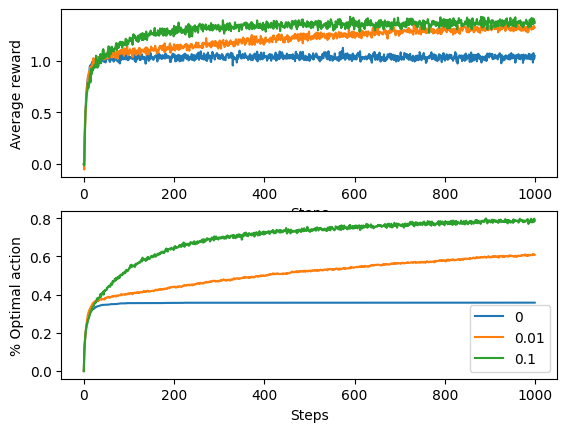

In [4]:
fig = plt.figure()
axs = fig.subplots(2,1)
for i in epsilon:
    values, optimals = run(runs = runs, bias = bias, k = k, t_end = t_end, constant = i)
    axs[0].plot(np.arange(0, t_end), values, label = f'eps = {i}')
    axs[1].plot(np.arange(0, t_end), optimals, label = f'{i}')
axs[0].set_xlabel('Steps')
axs[0].set_ylabel('Average reward')
axs[1].set_xlabel('Steps')
axs[1].set_ylabel('% Optimal action')
plt.legend()
plt.show()

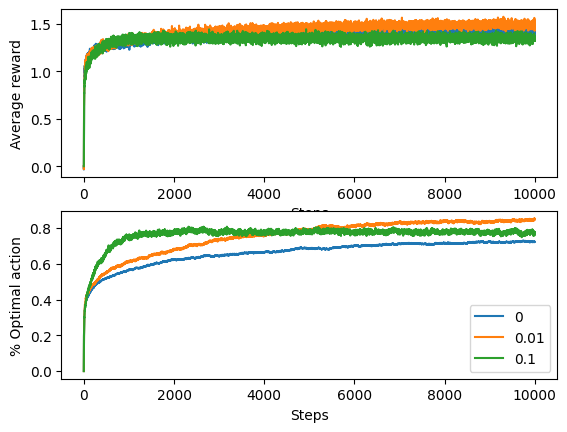

In [5]:
#Random walk
fig = plt.figure()
axs = fig.subplots(2,1)
t_end = 10000
for i in epsilon:
    values, optimals = run(runs = runs, bias = bias, k = k, t_end = t_end, constant = i, nonstationary='Yes', alpha = 0.1)
    axs[0].plot(np.arange(0, t_end), values, label = f'eps = {i}')
    axs[1].plot(np.arange(0, t_end), optimals, label = f'{i}')
axs[0].set_xlabel('Steps')
axs[0].set_ylabel('Average reward')
axs[1].set_xlabel('Steps')
axs[1].set_ylabel('% Optimal action')
plt.legend()
plt.show()

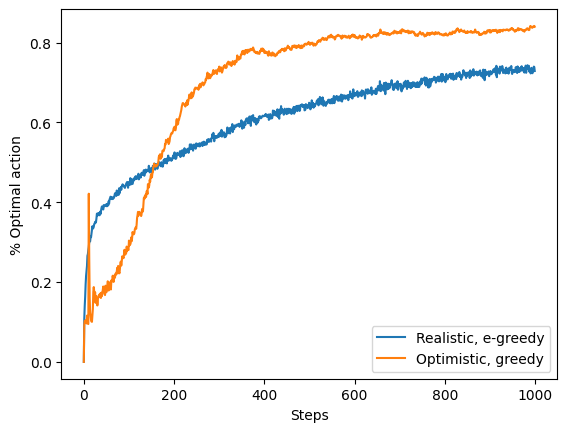

In [6]:
#figure 2.3
fig = plt.figure()
t_end = 1000

values, optimals = run(runs = runs, bias = bias, k = k, t_end = t_end, constant = 0.1, nonstationary='Yes', alpha = 0.1)
plt.plot(np.arange(0, t_end), optimals, label = f'Realistic, e-greedy')
values, optimals = run(runs = runs, bias = 5, k = k, t_end = t_end, constant = 0, nonstationary='Yes', alpha = 0.1)
plt.plot(np.arange(0, t_end), optimals, label = f'Optimistic, greedy')
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.legend()
plt.show()

/var/folders/yn/_skvc8wx3zx48hs2_ll4cpyc0000gp/T/ipykernel_8398/2803121871.py:8: RuntimeWarning: invalid value encountered in divide
  return np.argmax(Qt + constant * np.sqrt(np.divide(np.log(t), Nt)))
/var/folders/yn/_skvc8wx3zx48hs2_ll4cpyc0000gp/T/ipykernel_8398/2803121871.py:8: RuntimeWarning: divide by zero encountered in divide
  return np.argmax(Qt + constant * np.sqrt(np.divide(np.log(t), Nt)))


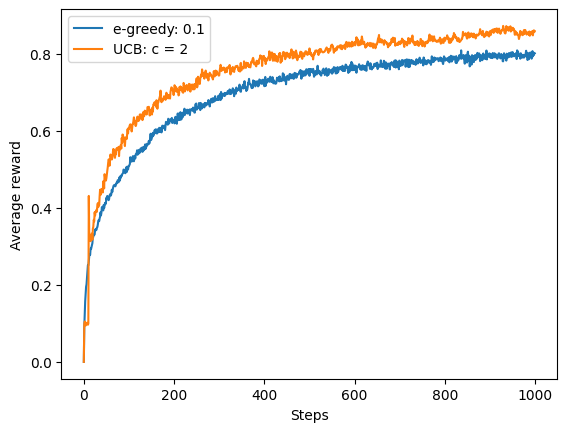

In [7]:
#figure 2.4
t_end = 1000
plt.figure()
values, optimals = run(runs = runs, bias = bias, k = k, t_end = t_end, constant = 0.1, nonstationary='No', selection = 'e-greedy')
plt.plot(np.arange(0, t_end), optimals, label = f'e-greedy: 0.1')
values, optimals = run(runs = runs, bias = bias, k = k, t_end = t_end, constant = 2, nonstationary='No', selection = 'upper-confidence-bound')
plt.plot(np.arange(0, t_end), optimals, label = f'UCB: c = 2')
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.legend()
plt.show()

In [8]:
def gradient_bandit(k = 10, alpha = 0, bias = 0, baseline = 0, t_end = 10):
    bandit = Environment(1, 1) #create environment, single state
    bandit.R = np.random.normal(size = k, loc = 4.0) #q*

    #lists for bookkeeping
    Nt = np.zeros(k) #number of times action is taken
    Ht = np.full(k, float(bias))
    R_average = baseline
    reward_log = np.zeros(t_end)
    optimal_action = np.zeros(t_end)

    t = 1
    while t != t_end:
        #softmax: boltzmann distribution
        pi = np.e**Ht / np.sum(np.e**Ht)
        #action selection
        At = np.random.choice(k, p = pi)
        q_star = bandit.R[At] #get reward for action
        Rt = np.random.normal(q_star)##received reward with noise
        
        #update rule
        # Nt[At] += 1
        # stepsize = 1 / Nt[At]
        # R_average += stepsize * (Rt - R_average)
        
        for a in range(k):
            if a == At:
                Ht[a] += alpha * (Rt - R_average) * (1 - pi[At])
            else:
                Ht[a] -= alpha * (Rt - R_average) * (pi[a])

        

        #bookkeeping for figures
        reward_log[t] = Rt
        if np.argmax(bandit.R) == At:
            optimal_action[t] = 1
        
        t+=1
    return reward_log, optimal_action

In [9]:
def run_gradient_ascent(runs, k, bias, baseline, t_end, alpha = 0.1):
    rewards_runs = np.zeros(t_end)
    optimal_run = np.zeros(t_end)
    for i in range(runs):
        reward, optimals = gradient_bandit(k = k, alpha = alpha, baseline = baseline, bias = bias, t_end = t_end)
        rewards_runs += reward
        optimal_run += optimals
    average_reward = np.divide(rewards_runs, runs)
    optimals = np.divide(optimal_run, runs)
    return average_reward, optimals

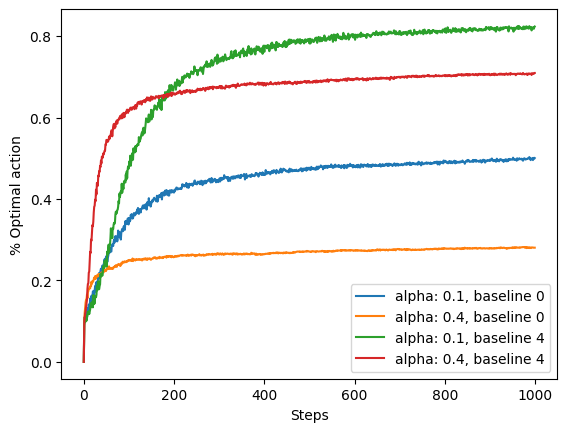

In [10]:
#figure 2.5 
t_end = 1000
plt.figure()
alpha = [0.1, 0.4]
baseline = [0, 4]
for j in baseline:
    for i in alpha:
        values, optimals = run_gradient_ascent(runs, k, bias, baseline = j, t_end = t_end, alpha = i)
        plt.plot(np.arange(0, t_end), optimals, label = f'alpha: {i}, baseline {j}')
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.legend()
plt.show()